<a href="https://colab.research.google.com/github/PhamTienLoc/FinalProjectML/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'league-of-legends-soloq-matches-at-10-minutes-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4745503%2F8047731%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T060632Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5143eb1c460e6bbce541f6139da107bd0a770df74771f3cb63fee22bb7417223b47395dcba3b2f0262e4ef8cd4a7cefa157596569e9342e684d57b1756f243c71caeafd19d60c38b11dbaed7d2119291525b63c1835d71ec1b301d1f6a6b5ca2d34f269525c49c5d6bb5e0439a1ccc75f2c788da3327f8f0d75bbfde5dfbff48c3d152f081afa75e2b53aecb4098fe254a1c472768d18d86a25deb10ef9d93e95fd2b915f0eba675479c5817d258a423178266e586f9a8a30ea02d202e6235ad2883d0cb67f8f1ae8c4c926b1537908c6e314e23b9062c1001f6b8d87b5c6ab43f7c0de752b4a85a2f0df483053855c4d98d57839ea8113627001c40d9ba643d,match-data-v5-with-headers-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4803485%2F8127551%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T060632Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D15fa59188cb83bcb34611160eabc770a5b0139a9a394f7459d3075d9f827d99b2a27c98ea821de0cebcd12067c96ac675df1af0765aebff40ebac2b5d358e94651c5336d4847a8b6c2cdb0248f0a4a147bc4cebfa3ab1d956d667130ad501b1999e0571401a47b395b13a0a12459d07cd5194f7138a9e50261dda74fc021fb9dddff71e00054d1730900e0d8336283cbb73e006a856026a2e5b85a07f5b16c0f6cb1cd6b24b2cc3f25fd80931e6a5d170764e2b9e51ab4eaa5ac9ca0b2ac939b72f772407ecf155bae7d9ea1b13f1381c59502ac4a7adc019496819c7fff9f1fc788c6c6d3b0ac5b74373db1dbbb81fdcdc1936a2dc284e5813342304fe57206'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1002513 bytes downloaded
Downloaded and uncompressed: league-of-legends-soloq-matches-at-10-minutes-2024
[==================================================] 998318 bytes downloaded
Downloaded and uncompressed: match-data-v5-with-headers-csv
Data source import complete.


In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
pd.set_option('display.max_columns', None)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import preprocessing, impute
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import pickle
from scipy import stats
import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")
random_state=1
np.random.seed(random_state)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_info_columns', 200)

In [4]:
!ls

sample_data


# Import Data

In [5]:
df = pd.read_csv('/kaggle/input/match-data-v5-with-headers-csv/match_data_v5_with_column.csv')
print(df.shape)
df.head(2)

(24225, 30)


matchId  blueTeamControlWardsPlaced  blueTeamWardsPlaced  blueTeamTotalKills  blueTeamDragonKills  blueTeamHeraldKills  blueTeamTowersDestroyed  blueTeamInhibitorsDestroyed  blueTeamTurretPlatesDestroyed  blueTeamFirstBlood  blueTeamMinionsKilled  blueTeamJungleMinions  blueTeamTotalGold  blueTeamXp  blueTeamTotalDamageToChamps  redTeamControlWardsPlaced  redTeamWardsPlaced  redTeamTotalKills  redTeamDragonKills  redTeamHeraldKills  redTeamTowersDestroyed  redTeamInhibitorsDestroyed  redTeamTurretPlatesDestroyed  redTeamMinionsKilled  redTeamJungleMinions  redTeamTotalGold  redTeamXp  redTeamTotalDamageToChamps  blueWin  Unnamed: 29
0  EUW1_6882489515'                           2                   23                   4                    2                    0                        0                            0                              7                   0                    388                    106              23923       29798                        21842                          6                  34                 16                   0                   0                       2                           0                             1                   400                    94             29637      32613                       27239        1          NaN
1  EUW1_6882416210'                           2                   46                  12                    1                    0                        1                            0                             10                   0                    348                     98              27852       30530                        35817                          6                  26                 17                   0                   0                       1                           0                             4                   373                    76             28970      30320                       36585        0          NaN

In [6]:
# Data Baic Fact

In [7]:
df.describe()

blueTeamControlWardsPlaced  blueTeamWardsPlaced  blueTeamTotalKills  blueTeamDragonKills  blueTeamHeraldKills  blueTeamTowersDestroyed  blueTeamInhibitorsDestroyed  blueTeamTurretPlatesDestroyed  blueTeamFirstBlood  blueTeamMinionsKilled  blueTeamJungleMinions  blueTeamTotalGold    blueTeamXp  blueTeamTotalDamageToChamps  redTeamControlWardsPlaced  redTeamWardsPlaced  redTeamTotalKills  redTeamDragonKills  redTeamHeraldKills  redTeamTowersDestroyed  redTeamInhibitorsDestroyed  redTeamTurretPlatesDestroyed  redTeamMinionsKilled  redTeamJungleMinions  redTeamTotalGold     redTeamXp  redTeamTotalDamageToChamps      blueWin  Unnamed: 29
count                24225.000000         24225.000000        24225.000000         24225.000000         24225.000000             24225.000000                 24225.000000                   24225.000000        24225.000000           24225.000000           24225.000000       24225.000000  24225.000000                 24225.000000               24225.000000        24225.000000       24225.000000        24225.000000        24225.000000            24225.000000                24225.000000                  24225.000000          24225.000000          24225.000000      24225.000000  24225.000000                24225.000000  24225.00000          0.0
mean                     3.610815            41.362023           12.792487             0.737833             0.123591                 0.654902                     0.002023                       8.915789            0.503860             349.240578              88.011393       27831.717771  29572.765119                 32173.245697                   3.643302           43.410898          12.863529            0.905635            0.103117                0.955088                    0.001527                      3.884045            350.287554             88.547368      27788.709391  29619.035789                32156.531682      0.49453          NaN
std                      2.018622            43.471913            4.910510             0.722126             0.329247                 0.885749                     0.054101                       3.083976            0.499995              31.339593              14.025502        2740.935799   1879.301846                  6131.399121                   2.026358           46.955275           4.850884            0.747582            0.304117                0.981776                    0.044021                      2.591134             31.593160             14.120346       2694.330794   1896.275564                 6041.175604      0.49998          NaN
min                      0.000000             9.000000            0.000000             0.000000             0.000000                 0.000000                     0.000000                       0.000000            0.000000             194.000000               0.000000       17719.000000  19061.000000                 11022.000000                   0.000000            9.000000           0.000000            0.000000            0.000000                0.000000                    0.000000                      0.000000            188.000000              0.000000      18247.000000  17602.000000                10383.000000      0.00000          NaN
25%                      2.000000            25.000000            9.000000             0.000000             0.000000                 0.000000                     0.000000                       7.000000            0.000000             329.000000              78.000000       25912.000000  28341.000000                 27933.000000                   2.000000           25.000000           9.000000            0.000000            0.000000                0.000000                    0.000000                      2.000000            330.000000             79.000000      25910.000000  28387.000000                28024.000000      0.00000          NaN
50%                      3.000000            29.000000           12.000000             1.000000             0.000000   

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24225 entries, 0 to 24224
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   matchId                        24225 non-null  object 
 1   blueTeamControlWardsPlaced     24225 non-null  int64  
 2   blueTeamWardsPlaced            24225 non-null  int64  
 3   blueTeamTotalKills             24225 non-null  int64  
 4   blueTeamDragonKills            24225 non-null  int64  
 5   blueTeamHeraldKills            24225 non-null  int64  
 6   blueTeamTowersDestroyed        24225 non-null  int64  
 7   blueTeamInhibitorsDestroyed    24225 non-null  int64  
 8   blueTeamTurretPlatesDestroyed  24225 non-null  int64  
 9   blueTeamFirstBlood             24225 non-null  int64  
 10  blueTeamMinionsKilled          24225 non-null  int64  
 11  blueTeamJungleMinions          24225 non-null  int64  
 12  blueTeamTotalGold              24225 non-null 

Check Numerical or Categorical features

In [9]:
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()
numericalfloat64_features = df.select_dtypes(include = ['float64']).columns.tolist()
numericalint64_features = df.select_dtypes(include = ['int64']).columns.tolist()

print('Number of categorical independent features: ', len(categorical_features))
print('Number of numerical float64 independent features: ', len(numericalfloat64_features))
print('Number of numerical int64 independent features: ', len(numericalint64_features))

Number of categorical independent features:  1
Number of numerical float64 independent features:  1
Number of numerical int64 independent features:  28


get the blue_num_int64_features features

In [10]:
blue_num_int64_features = numericalint64_features[:14]
print(len(blue_num_int64_features), blue_num_int64_features)
red_num_int64_features = numericalint64_features[14:-1]
print(len(red_num_int64_features), red_num_int64_features)

14 ['blueTeamControlWardsPlaced', 'blueTeamWardsPlaced', 'blueTeamTotalKills', 'blueTeamDragonKills', 'blueTeamHeraldKills', 'blueTeamTowersDestroyed', 'blueTeamInhibitorsDestroyed', 'blueTeamTurretPlatesDestroyed', 'blueTeamFirstBlood', 'blueTeamMinionsKilled', 'blueTeamJungleMinions', 'blueTeamTotalGold', 'blueTeamXp', 'blueTeamTotalDamageToChamps']
13 ['redTeamControlWardsPlaced', 'redTeamWardsPlaced', 'redTeamTotalKills', 'redTeamDragonKills', 'redTeamHeraldKills', 'redTeamTowersDestroyed', 'redTeamInhibitorsDestroyed', 'redTeamTurretPlatesDestroyed', 'redTeamMinionsKilled', 'redTeamJungleMinions', 'redTeamTotalGold', 'redTeamXp', 'redTeamTotalDamageToChamps']


In [11]:
df.shape

(24225, 30)

get_nan, cap_data, and ead basic functions

In [12]:
def get_nan(dataframe):
    total_nan = dataframe.isnull().sum()
    percent_nan = round(dataframe.isnull().sum()/len(dataframe)*100, 2)
    nan_col = pd.concat([total_nan, percent_nan], axis=1, keys=['Total', 'Percent'])
    nan_col = nan_col[nan_col['Total'] > 0].sort_values(by = ['Total'], ascending = False)
    return nan_col

def cap_data(df, q1, q3):
    for col in tqdm(df.columns):
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([q1,q3]).values
            ###########################################################
            ############ Replace the outliers with lower & upper limits
            ###########################################################
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

def eda(dataframe, features):
    data_info = [{"Minimum": dataframe[col].min(), "Maximum": dataframe[col].max(), "Mode": dataframe[col].mode()[0]} for col in features]
    return pd.DataFrame(data_info, index = features).T


# Handling Missing Values and Useless Features

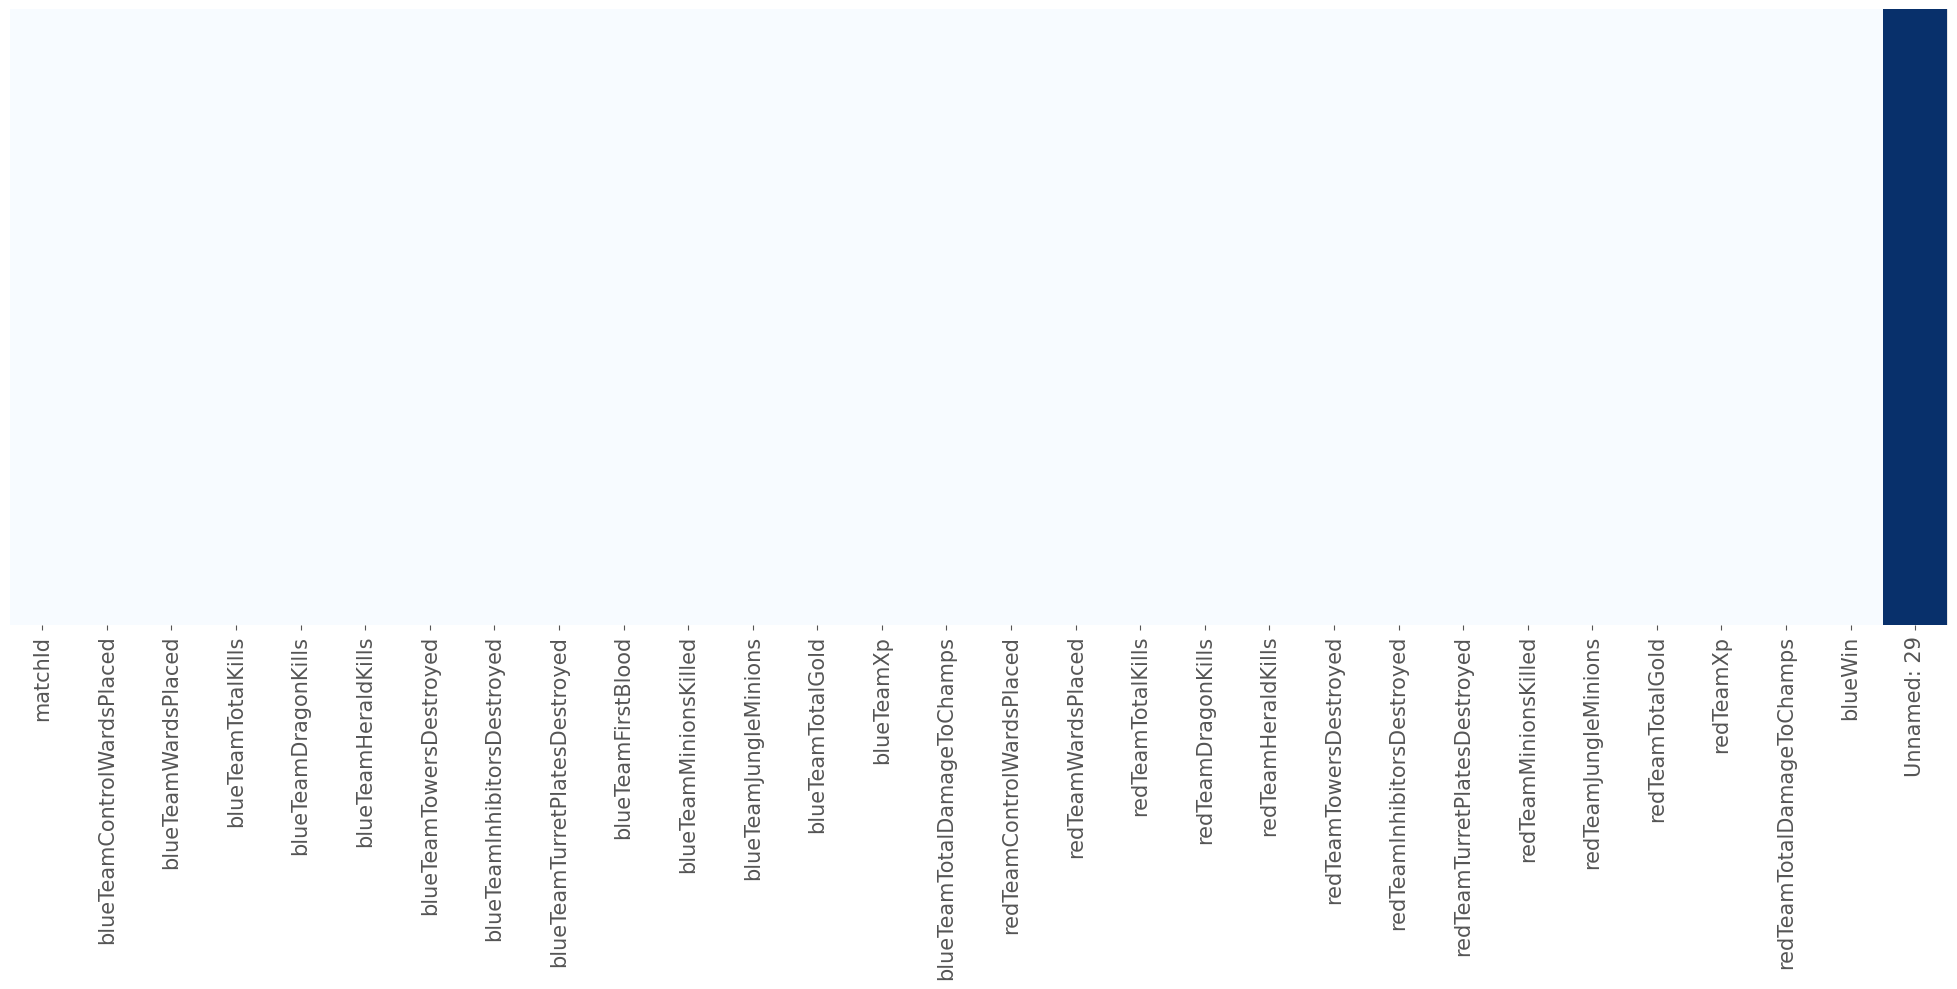

In [13]:
plt.figure(figsize = (25,8))
sns.heatmap(df.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.xticks(fontsize = 15,)
plt.ylabel(None)
plt.show()

In [14]:
print(get_nan(df).T)
print(df.shape)

         Unnamed: 29
Total        24225.0
Percent        100.0
(24225, 30)


Remove the useless columns

In [15]:
df = df.drop(df.columns[-1], axis=1)
df = df.drop(df.columns[0], axis=1)
print(get_nan(df).T)
print(df.shape)

Empty DataFrame
Columns: []
Index: [Total, Percent]
(24225, 28)


# Exploratory Data Analysis, EDA

## Data Correlation Analysis

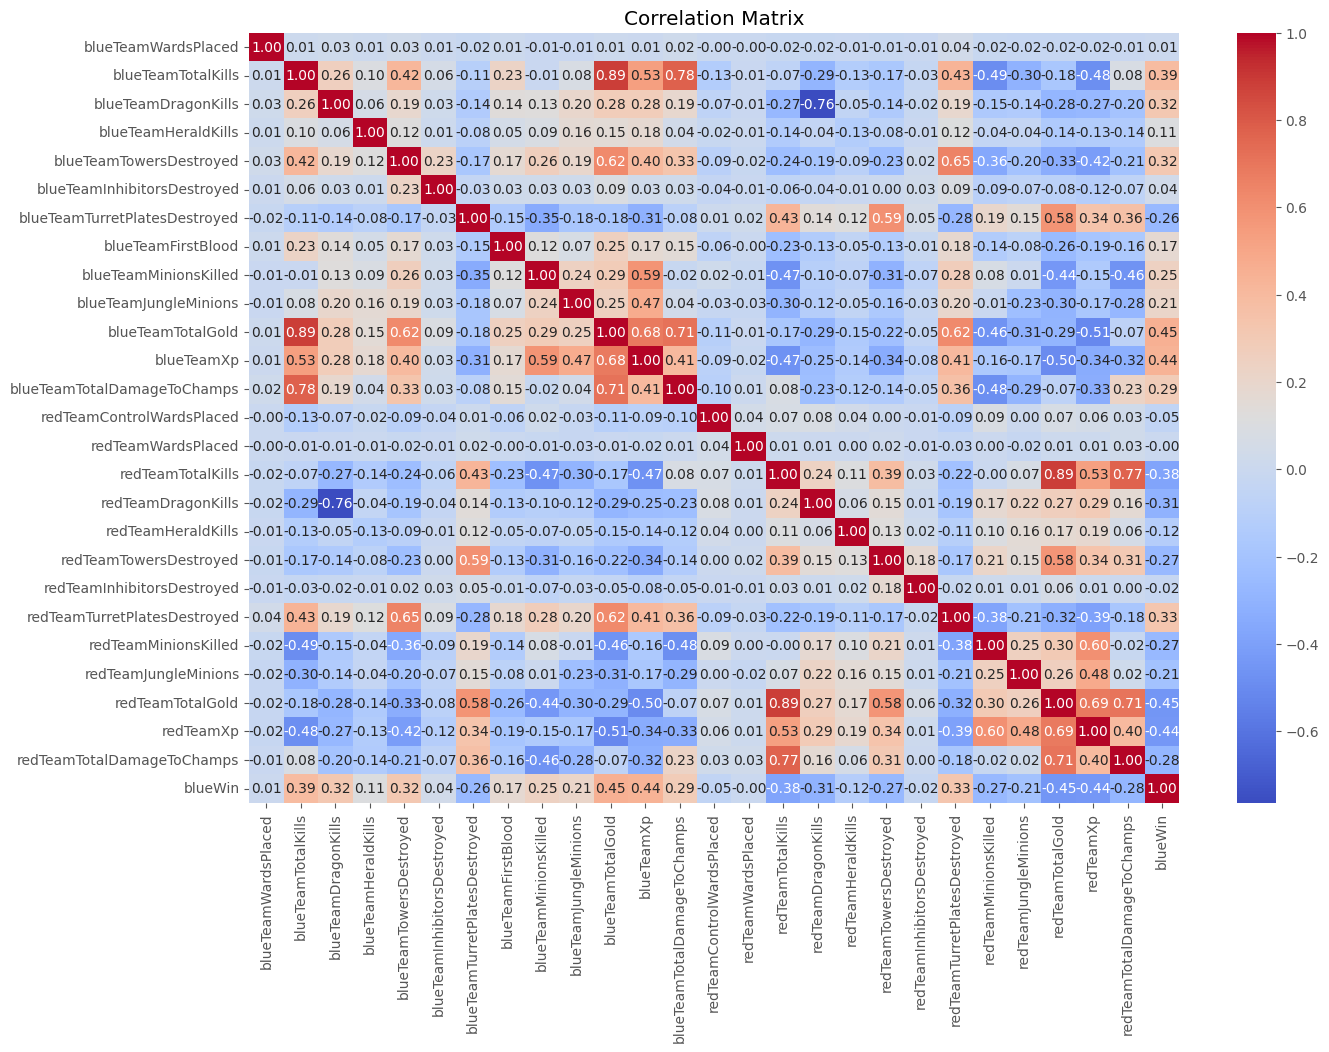

In [16]:
correlation_matrix = df.iloc[:, list(range(1, df.shape[1], 1))].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Handling Incorrect Data

In [17]:
df.rename(columns={'blueTeamTurretPlatesDestroyed': 'redTeamTurretPlatesDestroyed', 'redTeamTurretPlatesDestroyed': 'blueTeamTurretPlatesDestroyed'}, inplace=True)

remove1 = df[df['blueTeamTurretPlatesDestroyed'] > 15].index
df.drop(remove1, inplace=True)
remove2 = df[df['redTeamTurretPlatesDestroyed'] > 15].index
df.drop(remove2, inplace=True)
print ("Training set size after removing wrong data:", df.shape)

Training set size after removing wrong data: (23685, 28)


## Data Distribution Analysis

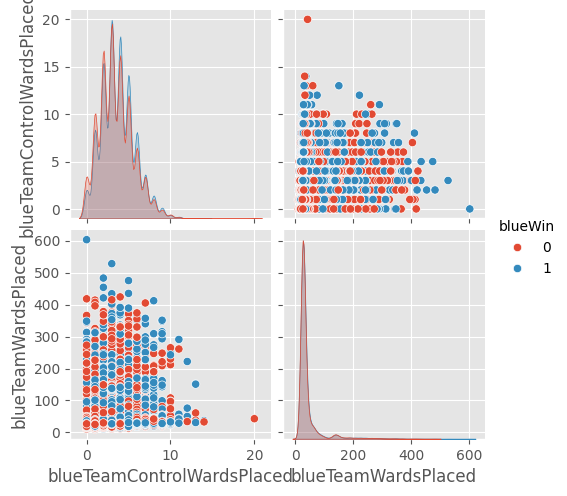

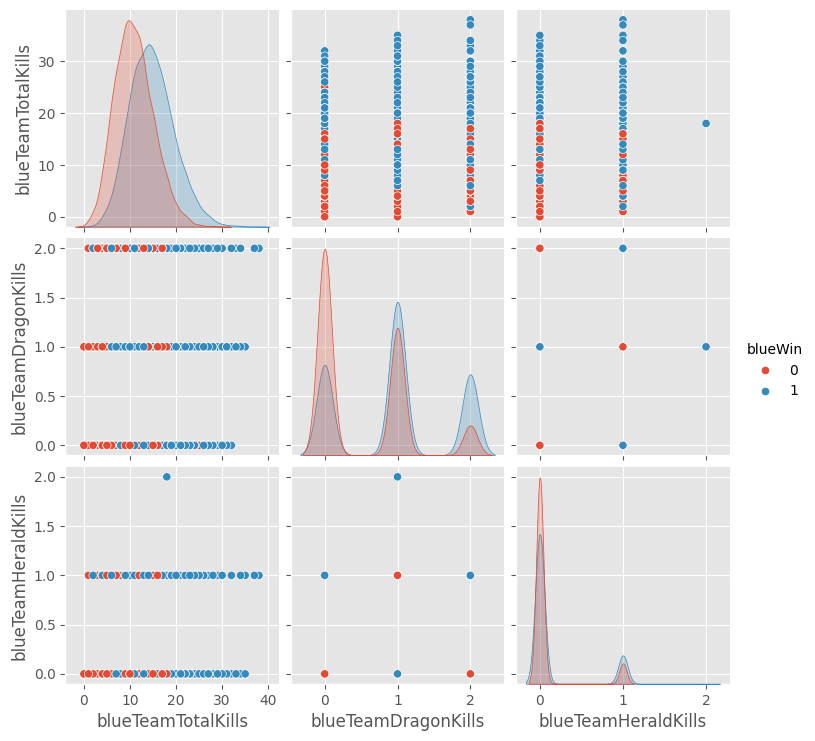

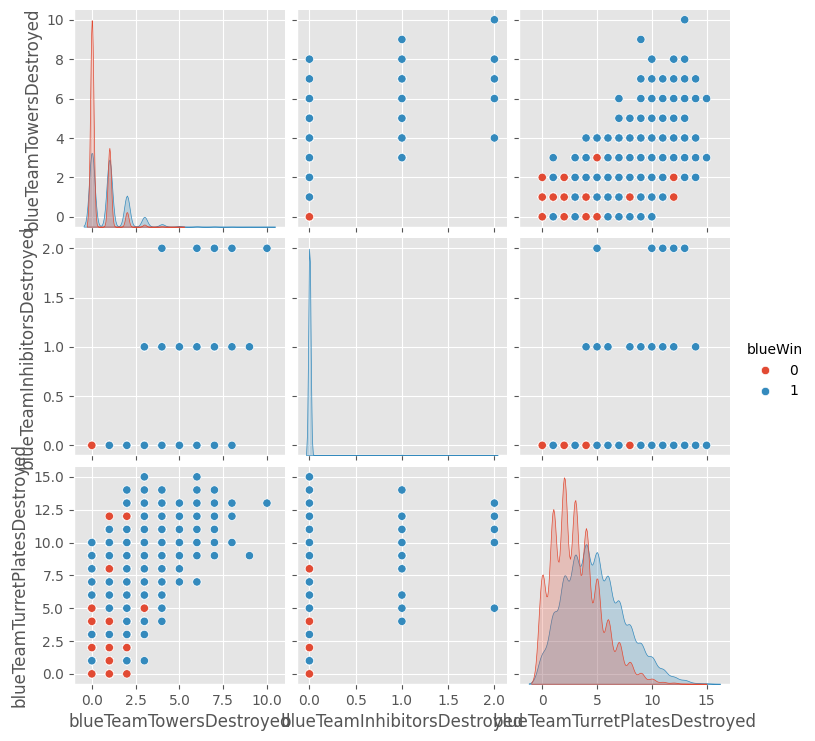

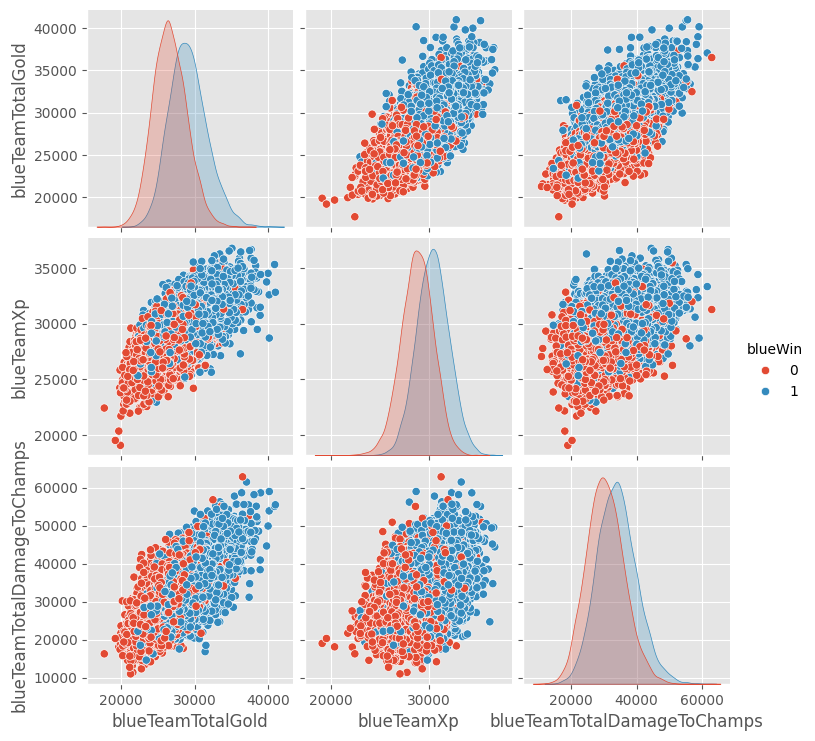

In [18]:
sns.pairplot(data=df, vars=('blueTeamControlWardsPlaced','blueTeamWardsPlaced'), hue='blueWin')
plt.show()
sns.pairplot(data=df, vars=('blueTeamTotalKills','blueTeamDragonKills','blueTeamHeraldKills'), hue='blueWin')
plt.show()
sns.pairplot(data=df, vars=('blueTeamTowersDestroyed','blueTeamInhibitorsDestroyed', 'blueTeamTurretPlatesDestroyed'), hue='blueWin')
plt.show()
sns.pairplot(data=df, vars=('blueTeamTotalGold','blueTeamXp','blueTeamTotalDamageToChamps'), hue='blueWin')
plt.show()

## Creating new faetures

In [19]:
df['diffMinionsKilled'] = (df['blueTeamMinionsKilled'] - df['redTeamMinionsKilled'])
df['diffJungleMinions'] = (df['blueTeamJungleMinions'] - df['redTeamJungleMinions'])
df['diffTotalGold'] = (df['blueTeamTotalGold'] - df['redTeamTotalGold'])
df['diffTotalKills'] = (df['blueTeamTotalKills'] - df['redTeamTotalKills'])
df['diffXp'] = (df['blueTeamXp'] - df['redTeamXp'])
df['diffTotalDamageToChamps'] = (df['blueTeamTotalDamageToChamps'] - df['redTeamTotalDamageToChamps'])
df['diffDragonKills'] = (df['blueTeamDragonKills'] - df['redTeamDragonKills'])
df['diffHeraldKills'] = (df['blueTeamHeraldKills'] - df['redTeamHeraldKills'])
df['diffTowersDestroyed'] = (df['blueTeamTowersDestroyed'] - df['redTeamTowersDestroyed'])
df['diffInhibitorsDestroyed'] = (df['blueTeamInhibitorsDestroyed'] - df['redTeamInhibitorsDestroyed'])
df['diffTurretPlatesDestroyed'] = (df['blueTeamTurretPlatesDestroyed'] - df['redTeamTurretPlatesDestroyed'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23685 entries, 0 to 24224
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   blueTeamControlWardsPlaced     23685 non-null  int64
 1   blueTeamWardsPlaced            23685 non-null  int64
 2   blueTeamTotalKills             23685 non-null  int64
 3   blueTeamDragonKills            23685 non-null  int64
 4   blueTeamHeraldKills            23685 non-null  int64
 5   blueTeamTowersDestroyed        23685 non-null  int64
 6   blueTeamInhibitorsDestroyed    23685 non-null  int64
 7   redTeamTurretPlatesDestroyed   23685 non-null  int64
 8   blueTeamFirstBlood             23685 non-null  int64
 9   blueTeamMinionsKilled          23685 non-null  int64
 10  blueTeamJungleMinions          23685 non-null  int64
 11  blueTeamTotalGold              23685 non-null  int64
 12  blueTeamXp                     23685 non-null  int64
 13  blueTeamTotalDamageTo

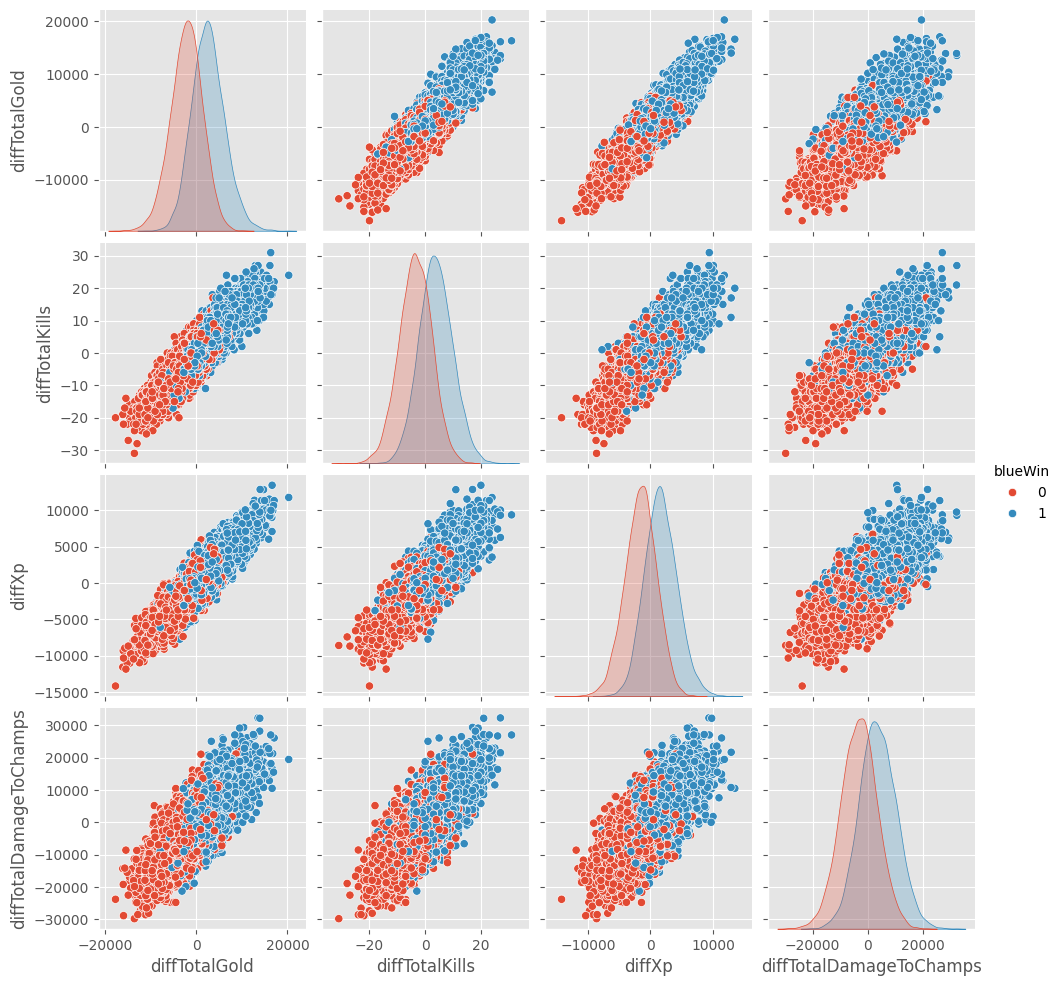

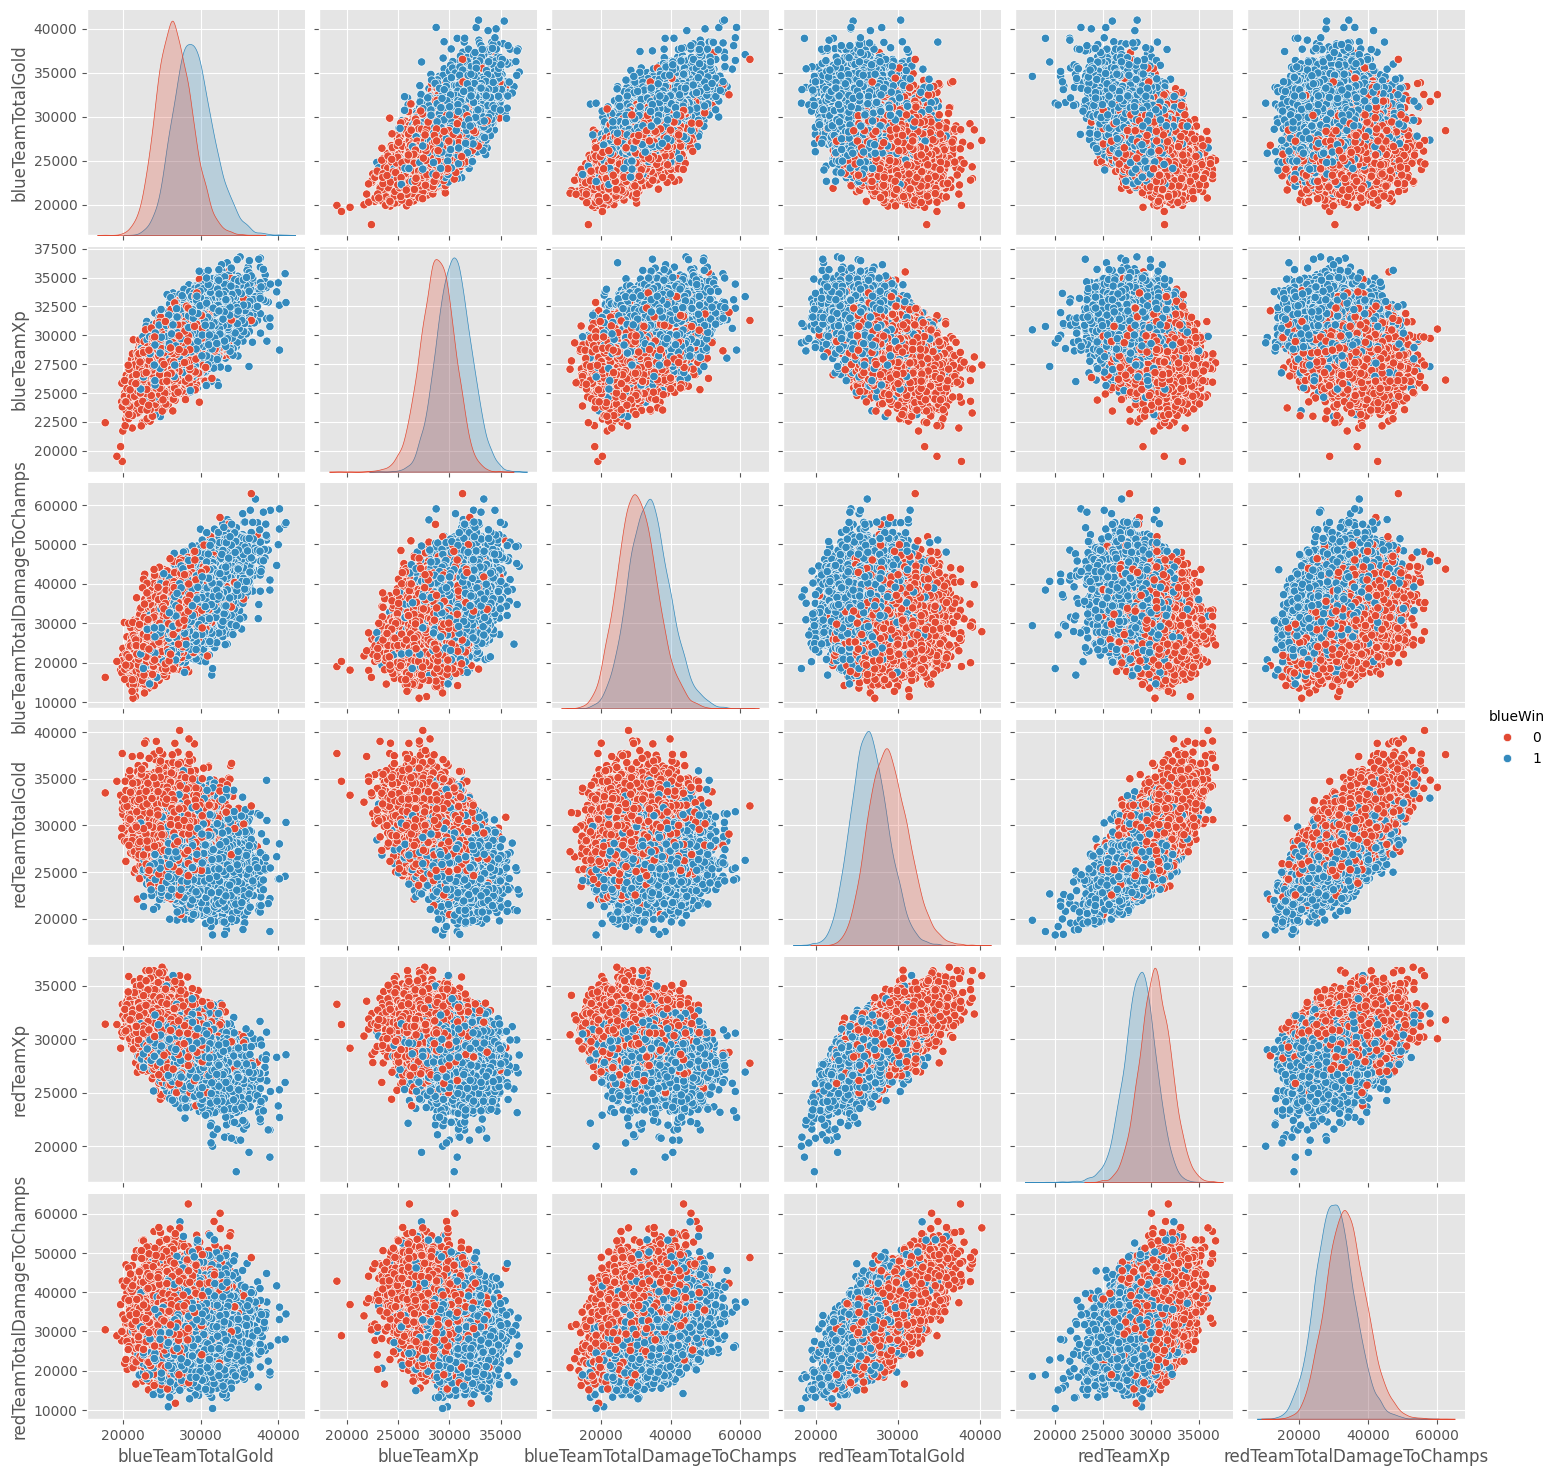

In [21]:
sns.pairplot(data=df, vars=('diffTotalGold','diffTotalKills','diffXp','diffTotalDamageToChamps'), hue='blueWin')
plt.show()

sns.pairplot(data=df, vars=('blueTeamTotalGold','blueTeamXp','blueTeamTotalDamageToChamps','redTeamTotalGold', 'redTeamXp', 'redTeamTotalDamageToChamps'), hue='blueWin')
plt.show()

## Handling Outliers

In [ ]:
fig, axes = plt.subplots(len(blue_num_int64_features), 3, figsize=(12, len(blue_num_int64_features)*4))

for i, col in tqdm(enumerate(blue_num_int64_features)):
    sns.histplot(df[col], ax = axes[i, 0], kde =True)
    stats.probplot(df[col].dropna(), dist='norm', plot=axes[i, 1])
    df.boxplot(column=col, ax=axes[i, 2])
    axes[i, 1].set_title(col)

plt.tight_layout()
plt.show()

14it [00:08,  1.72it/s]


In [ ]:
eda(df, numericalint64_features)

eda(df, numericalint64_features)

## Handling Imbalanced Dataset

In [ ]:
figure, axes = plt.subplots(figsize = (7, 3))

sns.countplot(data = df, x = 'blueWin', ax = axes)
axes.set(title = 'blueWin', xlabel = "blueWin", ylabel = "Count")

for p in axes.patches:
    height = p.get_height()
    axes.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
df.info()

# Data Split

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_lable = [
    # 'matchId',
    'blueTeamControlWardsPlaced',
    'blueTeamWardsPlaced',
    'blueTeamTotalKills',
    'blueTeamDragonKills',
    'blueTeamHeraldKills',
    'blueTeamTowersDestroyed',
    'blueTeamInhibitorsDestroyed',
    'blueTeamTurretPlatesDestroyed',
    'blueTeamFirstBlood',
    'blueTeamMinionsKilled',
    'blueTeamJungleMinions',
    'blueTeamTotalGold',
    'blueTeamXp',
    'blueTeamTotalDamageToChamps',

    'redTeamControlWardsPlaced',
    'redTeamWardsPlaced',
    'redTeamTotalKills',
    'redTeamDragonKills',
    'redTeamHeraldKills',
    'redTeamTowersDestroyed',
    'redTeamInhibitorsDestroyed',
    'redTeamTurretPlatesDestroyed',
    'redTeamMinionsKilled',
    'redTeamJungleMinions',
    'redTeamTotalGold',
    'redTeamXp',
    'redTeamTotalDamageToChamps',

    'diffMinionsKilled',
    'diffJungleMinions',
    'diffTotalGold',
    'diffTotalKills',
    'diffXp',
    'diffTotalDamageToChamps',

    'diffDragonKills',
    'diffHeraldKills',
    'diffTowersDestroyed',
    'diffInhibitorsDestroyed',
    'diffTurretPlatesDestroyed'
]

X = df[feature_lable]
y = df['blueWin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))
print(y.shape, X_train.shape)

# Visualization of Processed Data

In [ ]:
import matplotlib.pyplot as plt

n = len(feature_lable)
n_cols = 7
n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(35, n_rows*5))

for i, col in enumerate(feature_lable):
    if col == 'blueWin':
      continue
    r, c = i // n_cols, i % n_cols
    if i in [1, 6, 15, 20, 36]:
        sns.boxplot(df[col], ax=axs[r, c])
    elif i in [0, 3, 4, 5, 6, 7, 8, 14, 17, 18, 19, 20, 21, 33, 34, 35, 37]:
        sns.countplot(x=col, data=df, ax=axs[r, c])
    else:
        sns.histplot(df[col], ax=axs[r, c], kde=True)

if n % n_cols != 0:
    for j in range(n, n_rows*n_cols):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

# Modeling

## Select k

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

def find_bestKfeatures(model, score_func=f_classif):
  k = -1
  max_score = 0
  for i in range(1, 39):
    selector = SelectKBest(score_func=score_func, k=i)
    pipeline = Pipeline([('selector', selector), ('model', model)])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print("K: {}, score: {}".format(i, score))
    if score > max_score:
      k = i
      max_score = score
      selected_features_indices = selector.get_support(indices=True)
  print("The best K number: {}, score: {}".format(k, max_score))
  return list(selected_features_indices)

## Hyper-Parameter tuning

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

cv = StratifiedKFold(n_splits = 5, shuffle = True)

def train_model_with_random_search(model, param_grid, X_train, y_train, X_test, y_test, skf):
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10,
                                       scoring='accuracy', n_jobs=-1, cv=skf)

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    best_param = random_search.best_params_
    print('Best Parameters: ', best_param)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    prob = best_model.predict_proba(X_test)
    prob = prob[:, 1]
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)


    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")

    sns.heatmap(confusion_matrix(y_test, y_pred), ax = axes[1], annot = True, cbar = False, fmt='.0f')
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')

    plt.show()

    return model, accuracy, f1, roc_auc, best_param

def train_model_with_phase_search(model, list_param_grid, X_train, y_train, X_test, y_test, skf):
    best_param = {}
    for grid in list_param_grid:
        for key, param in best_param.items():
            best_param[key] = [param]

        curr_grid = best_param | grid
        print(curr_grid)
        grid_search = GridSearchCV(model,curr_grid, n_jobs=-1, cv=skf)

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_param = grid_search.best_params_
    print('Best Parameters: ', best_param)
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    prob = best_model.predict_proba(X_test)
    prob = prob[:, 1]
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)

    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")

    sns.heatmap(confusion_matrix(y_test, y_pred), ax = axes[1], annot = True, cbar = False, fmt='.0f')
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')

    plt.show()

    return model, accuracy, f1, roc_auc, best_param

## Logistic Regression

In [ ]:
log_reg_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'liblinear'],
    'max_iter': [100, 200, 300, 400, 500]
}

log_reg_param_grid_phase = [{'max_iter': [100, 200, 300, 400, 500], 'solver': ['newton-cg', 'liblinear']}, {'penalty': ['l1', 'l2', 'elasticnet'],'C': [0.001, 0.01, 0.1, 1, 10, 100],}]

model_lr = LogisticRegression()
lr_features = find_bestKfeatures(model_lr, score_func=f_classif)
X_train_lr, X_test_lr = X_train[:, lr_features], X_test[:, lr_features]
time_start = time.time()
model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample = train_model_with_random_search(model_lr, log_reg_param_grid, X_train_lr, y_train, X_test_lr, y_test, cv)
model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase = train_model_with_phase_search(model_lr, log_reg_param_grid_phase, X_train_lr, y_train, X_test_lr, y_test, cv)
time_taken_lr = time.time() - time_start
if acc_sample >= acc_phase:
    model_lr, acc_lr, f1_lr, roc_auc_lr, param_lr = model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample
else:
    model_lr, acc_lr, f1_lr, roc_auc_lr, param_lr = model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase

In [ ]:
print('Best Parameters: ', param_lr)
print("Time Taken: ", round(time_taken_lr, 2), ' Seconds')

## Desicison Tree

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 3, 4, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [1, 2, 4]
}

dt_param_grid_phase = [{'splitter': ['best'], 'max_depth': [None, 3, 4, 5, 10, 20, 30, 40, 50]}, {'criterion': ['gini', 'entropy']}, {'min_samples_split': [10, 15, 20],'min_samples_leaf': [1, 2, 4]}]


model_dt = DecisionTreeClassifier()

dt_features = find_bestKfeatures(model_dt, score_func=f_classif)
X_train_dt, X_test_dt = X_train[:, dt_features], X_test[:, dt_features]
time_start = time.time()
model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample = train_model_with_random_search(model_dt, dt_param_grid, X_train_dt, y_train, X_test_dt, y_test, cv)
model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase = train_model_with_phase_search(model_dt, dt_param_grid_phase, X_train_dt, y_train, X_test_dt, y_test, cv)
time_taken_dt = time.time() - time_start
if acc_sample >= acc_phase:
    model_dt, acc_dt, f1_dt, roc_auc_dt, param_dt = model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample
else:
    model_dt, acc_dt, f1_dt, roc_auc_dt, param_dt = model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase

In [ ]:
print('Best Parameters: ', param_dt)
print("Time Taken: ", round(time_taken_dt, 2), ' Seconds')

## RandomForestClassifier

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini'],
    'max_depth': [None, 3, 4, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_param_grid_phase = [{'criterion': ['gini']}, {'n_estimators': [100, 200, 300], 'bootstrap': [True, False]}, {'max_depth': [None, 3, 4, 5, 10, 20, 30, 40, 50]}, {'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}]

model_rf = RandomForestClassifier()

rf_features = find_bestKfeatures(model_rf, score_func=f_classif)
X_train_rf, X_test_rf = X_train[:, rf_features], X_test[:, rf_features]
time_start = time.time()
model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample = train_model_with_random_search(model_rf, rf_param_grid, X_train_rf, y_train, X_test_rf, y_test, cv)
model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase = train_model_with_phase_search(model_rf, rf_param_grid_phase, X_train_rf, y_train, X_test_rf, y_test, cv)
time_taken_rf = time.time() - time_start
if acc_sample >= acc_phase:
    model_rf, acc_rf, f1_rf, roc_auc_rf, param_rf = model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample
else:
    model_rf, acc_rf, f1_rf, roc_auc_rf, param_rf = model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase

In [ ]:
print('Best Parameters: ', param_rf)
print("Time Taken: ", round(time_taken_rf, 2), ' Seconds')

## XGBoost

In [ ]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0.5, 1],
    'reg_lambda': [0, 1, 5]
}

xgb_param_grid_phase = [{'learning_rate': [0.01, 0.05, 0.1],'n_estimators': [100, 200]}, {'max_depth': [3, 5, 7, 9], 'gamma': [0, 1, 5]}, {'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]}, {'reg_alpha': [0.5, 1],'reg_lambda': [0, 1, 5]}]

model_xgb = xgb.XGBClassifier()

xgb_features = find_bestKfeatures(model_xgb, score_func=f_classif)
X_train_xgb, X_test_xgb = X_train[:, xgb_features], X_test[:, xgb_features]
time_start = time.time()
model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample = train_model_with_random_search(model_xgb, xgb_param_grid, X_train_xgb, y_train, X_test_xgb, y_test, cv)
model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase = train_model_with_phase_search(model_xgb, xgb_param_grid_phase, X_train_xgb, y_train, X_test_xgb, y_test, cv)
time_taken_xgb = time.time() - time_start
if acc_sample >= acc_phase:
    model_xgb, acc_xgb, f1_xgb, roc_auc_xgb, param_xgb = model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample
else:
    model_xgb, acc_xgb, f1_xgb, roc_auc_xgb, param_xgb = model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase

In [ ]:
print('Best Parameters: ', param_xgb)
print("Time Taken: ", round(time_taken_xgb, 2), ' Seconds')

## GradientBoostingClassifier

In [ ]:
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 3, 4, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'loss' : ['log_loss', 'exponential'],
    'criterion' : ['friedman_mse', 'squared_error']
}

gb_param_grid_phase = [{'learning_rate': [0.01, 0.05, 0.1, 0.2], 'n_estimators': [100, 200]}, {'max_depth': [None, 3, 4, 5, 10, 20]}, {'loss' : ['log_loss', 'exponential'], 'criterion' : ['friedman_mse', 'squared_error']}]


model_gb = GradientBoostingClassifier()

gb_features = find_bestKfeatures(model_gb, score_func=f_classif)
X_train_gb, X_test_gb = X_train[:, gb_features], X_test[:, gb_features]
time_start = time.time()
model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample = train_model_with_random_search(model_gb, gb_param_grid, X_train_gb, y_train, X_test_gb, y_test, cv)
model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase = train_model_with_phase_search(model_gb, gb_param_grid_phase, X_train_gb, y_train, X_test_gb, y_test, cv)
time_taken_gb = time.time() - time_start
if acc_sample >= acc_phase:
    model_gb, acc_gb, f1_gb, roc_auc_gb, param_gb = model_sample, acc_sample, f1_sample, roc_auc_sample, param_sample
else:
    model_gb, acc_gb, f1_gb, roc_auc_gb, param_gb = model_phase, acc_phase, f1_phase, roc_auc_phase, param_phase

In [ ]:
print('Best Parameters: ', param_gb)
print("Time Taken: ", round(time_taken_gb, 2), ' Seconds')

# Comparision

In [ ]:
accuracies = [acc_lr, acc_dt, acc_rf, acc_xgb, acc_gb]
f_score = [f1_lr, f1_dt, f1_rf, f1_xgb, f1_gb]
roc_auc = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_xgb, roc_auc_gb]
time = [time_taken_lr, time_taken_dt, time_taken_rf, time_taken_xgb, time_taken_gb]

final_df = pd.DataFrame({"Accuracies": accuracies, "F1 Scores": f_score, "ROC AUC": roc_auc, "Time Taken": time},
                       index = ['LogisticReg', 'DecisionTree', 'RandomForest', 'XGB', 'GB'])
final_df = final_df.round(4)
final_df